# Финальный проект
#### Content-based рекомендательная система для подбора постов в ленте пользователя соцсети

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.__version__

'1.4.2'

In [2]:
# Загрузка данных для обучения из БД

df_users = pd.read_sql(
    """
SELECT * FROM public.user_data
    """,
con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
            "postgres.lab.karpov.courses:6432/startml"
)

df_users.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [3]:
df_post = pd.read_sql(
    """
SELECT * FROM public.post_text_df
    """,
con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
            "postgres.lab.karpov.courses:6432/startml"
)

df_post.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [32]:
df_feed = pd.read_sql(
    """
SELECT timestamp, user_id, post_id, target
FROM public.feed_data
WHERE action != 'like'
LIMIT 2000000
    """,
con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
            "postgres.lab.karpov.courses:6432/startml"
)

df_feed.head()

,timestamp,user_id,post_id,target
0,2021-10-26 17:03:06,142172,1948,0
1,2021-10-26 17:03:27,142172,1569,0
2,2021-10-26 17:04:35,142172,2179,0
3,2021-10-26 17:05:10,142172,1665,0
4,2021-10-26 17:06:02,142172,3429,0


In [33]:
# Создание датафрейма с признаками для обучения модели

data = df_feed.merge(df_users, left_on='user_id', right_on='user_id') \
        .merge(df_post, left_on='post_id', right_on='post_id')

In [34]:
# В данных есть выраженный дисбаланс классов

print(data['target'].value_counts())
print()
print(data['target'].value_counts()[0] / data['target'].value_counts()[1], '% positive class')

0    1761141
1     238859
Name: target, dtype: int64

7.373140639456751 % positive class


In [35]:
data.isna().sum()

timestamp    0
user_id      0
post_id      0
target       0
gender       0
age          0
country      0
city         0
exp_group    0
os           0
source       0
text         0
topic        0
dtype: int64

In [36]:
data.head()

,timestamp,user_id,post_id,target,gender,age,country,city,exp_group,os,source,text,topic
0,2021-10-26 17:03:06,142172,1948,0,0,33,Russia,Rostov,1,Android,organic,Joke e-mail virus tricks users\n\nA virus that...,tech
1,2021-11-21 09:28:40,107396,1948,0,0,28,Russia,Chelyabinsk,1,iOS,organic,Joke e-mail virus tricks users\n\nA virus that...,tech
2,2021-10-17 18:05:35,28241,1948,0,0,34,Russia,Galenki,1,Android,ads,Joke e-mail virus tricks users\n\nA virus that...,tech
3,2021-11-25 14:31:14,135254,1948,0,0,22,Ukraine,Vinnytsia,2,iOS,organic,Joke e-mail virus tricks users\n\nA virus that...,tech
4,2021-10-25 18:39:26,52060,1948,0,1,28,Russia,Krasnoyarsk,4,Android,ads,Joke e-mail virus tricks users\n\nA virus that...,tech


In [37]:
data['exp_group'] = data['exp_group'].astype('object')
data['timestamp'] = pd.to_datetime(data['timestamp'])

cat_cols = data.loc[:, data.dtypes == np.object].columns
num_cols = data.loc[:, data.dtypes != np.object].columns

C:\Users\user\AppData\Local\Temp\ipykernel_17940\3369054387.py:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat_cols = data.loc[:, data.dtypes == np.object].columns
C:\Users\user\AppData\Local\Temp\ipykernel_17940\3369054387.py:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_cols = data.loc[:, data.dtypes != np.object].columns


In [38]:
data[cat_cols].describe()

,country,city,exp_group,os,source,text,topic
count,2000000,2000000,2000000,2000000,2000000,2000000,2000000
unique,11,1115,5,2,2,6747,7
top,Russia,Moscow,2,Android,organic,Hantuchova in Dubai last eight\n\nDaniela Hant...,movie
freq,1772435,278976,407951,1290980,1024933,1335,739686


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='age'>

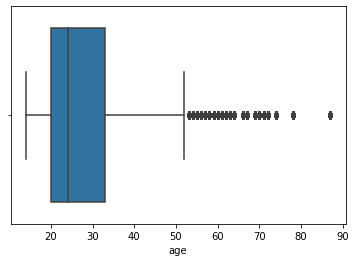

In [39]:
sns.boxplot(data['age'])

In [40]:
# Вытащим из timestamp признаки связанные со временем

data['weekday'] = data['timestamp'].dt.dayofweek
data['hour'] = data['timestamp'].dt.hour
data['num_of_day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month

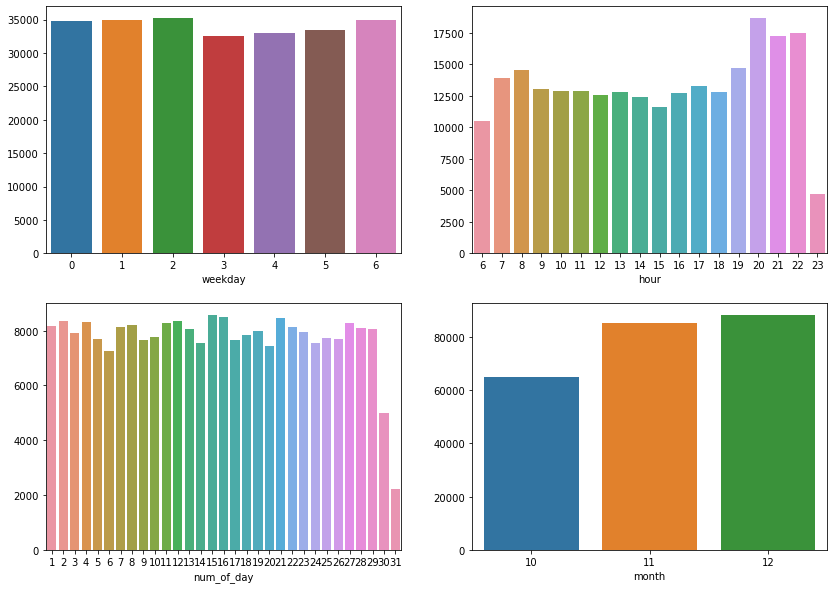

In [41]:
fig = plt.figure()
fig.set_size_inches(14, 10)

for i, col in zip(range(1, 5), ['weekday', 'hour', 'num_of_day', 'month']):
    
    ax = fig.add_subplot(2, 2, i)
    sns.barplot(y=data[data['target'] == 1].groupby(col)['target'].count().values,
                 x=data[data['target'] == 1].groupby(col)['target'].count().index)

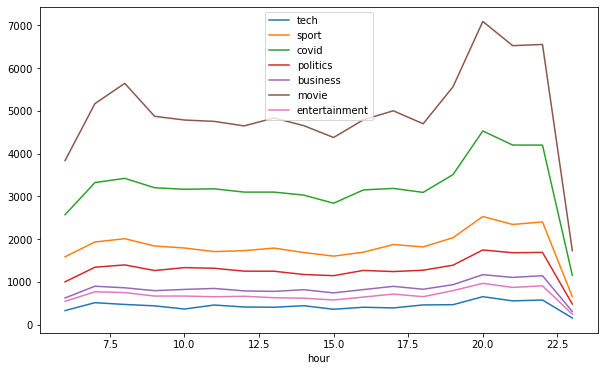

In [42]:
fig = plt.figure()
fig.set_size_inches(10, 6)

for topic in data['topic'].unique():
    
    sns.lineplot(x=data[(data['topic'] == topic) & ( data['target'] == 1)].groupby('hour')['target'].count().index,
                y=data[(data['topic'] == topic) & ( data['target'] == 1)].groupby('hour')['target'].count().values)
    plt.legend(data['topic'].unique())

In [43]:
# Создание новых бинарных признаков - утро и вечер

data['is_morning'] = 0
data['is_morning'].loc[data['hour'].isin([7, 8, 9])] = 1

data['is_eve'] = 0
data['is_eve'].loc[data['hour'].isin([19, 20, 21, 22])] = 1

C:\Users\user\AppData\Local\Temp\ipykernel_17940\3724644080.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_morning'].loc[data['hour'].isin([7, 8, 9])] = 1
C:\Users\user\AppData\Local\Temp\ipykernel_17940\3724644080.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_eve'].loc[data['hour'].isin([19, 20, 21, 22])] = 1


In [44]:
data = data.drop(['weekday', 'hour', 'num_of_day', 'month'], axis=1)

In [67]:
# Разбиение датасета на трейн и тест по принципу Timesplit 

data = data.sort_values(by='timestamp')
train = data.iloc[:-200000].copy()
test = data.iloc[-200000:].copy()
train.head()

,timestamp,user_id,post_id,target,gender,age,country,city,exp_group,os,source,text,topic,is_morning,is_eve
1181830,2021-10-01 06:01:52,121367,5289,0,1,30,Russia,Samara,0,Android,organic,What an incredible fall for Sean Ellis.You gat...,movie,0,0
1449360,2021-10-01 06:01:52,128167,6206,0,1,18,Russia,Vladivostok,2,iOS,organic,I have just recently purchased collection one ...,movie,0,0
564552,2021-10-01 06:02:00,107512,5590,0,1,17,Russia,Murom,3,Android,organic,The latest Rumor going around is that Vh1 is s...,movie,0,0
1448056,2021-10-01 06:02:00,92597,2355,0,1,28,Russia,Moscow,0,Android,ads,#COVID19 #COVIDー19 is a HOAX!!! Prove me wrong...,covid,0,0
647856,2021-10-01 06:02:00,155119,4129,0,1,23,Russia,Omsk,0,Android,organic,Stories about embezzlement of #COVID19 funds i...,covid,0,0


In [68]:
train = train.drop(['timestamp', 'user_id', 'post_id'], axis=1)
test = test.drop(['timestamp', 'user_id', 'post_id'], axis=1)

In [69]:
X_train, y_train = train.drop('target', axis=1), train['target']
X_test, y_test = test.drop('target', axis=1), test['target']

In [26]:
# Обучение модели

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders.cat_boost import CatBoostEncoder
from catboost import CatBoostClassifier

obj_cols = ['country', 'city', 'exp_group', 'os', 'source', 'topic']

cat = CatBoostClassifier(cat_features=obj_cols, text_features=['text'], auto_class_weights='Balanced')

cat.fit(X_train, y_train)

Learning rate set to 0.252892
0:	learn: 0.6813638	total: 2.46s	remaining: 40m 55s
1:	learn: 0.6726778	total: 4.67s	remaining: 38m 47s
2:	learn: 0.6683938	total: 7.18s	remaining: 39m 48s
3:	learn: 0.6658830	total: 9.16s	remaining: 38m 2s
4:	learn: 0.6638647	total: 11.3s	remaining: 37m 27s
5:	learn: 0.6627235	total: 13.3s	remaining: 36m 43s
6:	learn: 0.6618770	total: 15.2s	remaining: 36m 2s
7:	learn: 0.6601826	total: 17.4s	remaining: 35m 55s
8:	learn: 0.6593995	total: 19.9s	remaining: 36m 28s
9:	learn: 0.6576891	total: 21.9s	remaining: 36m 8s
10:	learn: 0.6570912	total: 24.3s	remaining: 36m 26s
11:	learn: 0.6565474	total: 27s	remaining: 36m 59s
12:	learn: 0.6562805	total: 28.8s	remaining: 36m 26s
13:	learn: 0.6559880	total: 30.8s	remaining: 36m 11s
14:	learn: 0.6541302	total: 33.5s	remaining: 36m 38s
15:	learn: 0.6535787	total: 35.4s	remaining: 36m 14s
16:	learn: 0.6532249	total: 37.3s	remaining: 35m 55s
17:	learn: 0.6529136	total: 39.6s	remaining: 35m 59s
18:	learn: 0.6525497	total: 41.

153:	learn: 0.6336473	total: 4m 54s	remaining: 27m
154:	learn: 0.6335708	total: 4m 57s	remaining: 26m 59s
155:	learn: 0.6334842	total: 4m 59s	remaining: 26m 57s
156:	learn: 0.6333623	total: 5m 1s	remaining: 26m 57s
157:	learn: 0.6332947	total: 5m 2s	remaining: 26m 53s
158:	learn: 0.6332179	total: 5m 4s	remaining: 26m 50s
159:	learn: 0.6331388	total: 5m 6s	remaining: 26m 49s
160:	learn: 0.6330808	total: 5m 8s	remaining: 26m 47s
161:	learn: 0.6330036	total: 5m 10s	remaining: 26m 45s
162:	learn: 0.6329296	total: 5m 12s	remaining: 26m 45s
163:	learn: 0.6328352	total: 5m 14s	remaining: 26m 45s
164:	learn: 0.6327346	total: 5m 17s	remaining: 26m 45s
165:	learn: 0.6326549	total: 5m 19s	remaining: 26m 44s
166:	learn: 0.6326171	total: 5m 21s	remaining: 26m 43s
167:	learn: 0.6325748	total: 5m 23s	remaining: 26m 43s
168:	learn: 0.6325070	total: 5m 25s	remaining: 26m 40s
169:	learn: 0.6324264	total: 5m 27s	remaining: 26m 38s
170:	learn: 0.6323252	total: 5m 29s	remaining: 26m 36s
171:	learn: 0.63222

304:	learn: 0.6249909	total: 9m 39s	remaining: 21m 59s
305:	learn: 0.6249266	total: 9m 40s	remaining: 21m 57s
306:	learn: 0.6248944	total: 9m 42s	remaining: 21m 55s
307:	learn: 0.6248630	total: 9m 44s	remaining: 21m 53s
308:	learn: 0.6248037	total: 9m 46s	remaining: 21m 52s
309:	learn: 0.6247703	total: 9m 48s	remaining: 21m 50s
310:	learn: 0.6247199	total: 9m 50s	remaining: 21m 48s
311:	learn: 0.6246641	total: 9m 52s	remaining: 21m 46s
312:	learn: 0.6246323	total: 9m 53s	remaining: 21m 43s
313:	learn: 0.6245893	total: 9m 55s	remaining: 21m 41s
314:	learn: 0.6245516	total: 9m 57s	remaining: 21m 39s
315:	learn: 0.6245326	total: 9m 59s	remaining: 21m 37s
316:	learn: 0.6244836	total: 10m 1s	remaining: 21m 34s
317:	learn: 0.6244429	total: 10m 2s	remaining: 21m 32s
318:	learn: 0.6244232	total: 10m 4s	remaining: 21m 29s
319:	learn: 0.6243936	total: 10m 5s	remaining: 21m 27s
320:	learn: 0.6243535	total: 10m 7s	remaining: 21m 25s
321:	learn: 0.6242906	total: 10m 9s	remaining: 21m 23s
322:	learn

452:	learn: 0.6196357	total: 14m 6s	remaining: 17m 2s
453:	learn: 0.6196118	total: 14m 8s	remaining: 17m
454:	learn: 0.6195832	total: 14m 10s	remaining: 16m 58s
455:	learn: 0.6195661	total: 14m 12s	remaining: 16m 57s
456:	learn: 0.6195363	total: 14m 14s	remaining: 16m 55s
457:	learn: 0.6194942	total: 14m 16s	remaining: 16m 53s
458:	learn: 0.6194587	total: 14m 17s	remaining: 16m 51s
459:	learn: 0.6194180	total: 14m 19s	remaining: 16m 48s
460:	learn: 0.6193815	total: 14m 21s	remaining: 16m 47s
461:	learn: 0.6193609	total: 14m 23s	remaining: 16m 45s
462:	learn: 0.6193253	total: 14m 24s	remaining: 16m 43s
463:	learn: 0.6192947	total: 14m 26s	remaining: 16m 41s
464:	learn: 0.6192455	total: 14m 28s	remaining: 16m 39s
465:	learn: 0.6192105	total: 14m 30s	remaining: 16m 37s
466:	learn: 0.6191726	total: 14m 32s	remaining: 16m 35s
467:	learn: 0.6191127	total: 14m 34s	remaining: 16m 34s
468:	learn: 0.6190702	total: 14m 36s	remaining: 16m 32s
469:	learn: 0.6190323	total: 14m 38s	remaining: 16m 30s

600:	learn: 0.6152817	total: 18m 41s	remaining: 12m 24s
601:	learn: 0.6152383	total: 18m 43s	remaining: 12m 22s
602:	learn: 0.6152118	total: 18m 45s	remaining: 12m 20s
603:	learn: 0.6151927	total: 18m 47s	remaining: 12m 19s
604:	learn: 0.6151765	total: 18m 49s	remaining: 12m 17s
605:	learn: 0.6151522	total: 18m 50s	remaining: 12m 15s
606:	learn: 0.6151210	total: 18m 52s	remaining: 12m 13s
607:	learn: 0.6150861	total: 18m 54s	remaining: 12m 11s
608:	learn: 0.6150481	total: 18m 56s	remaining: 12m 9s
609:	learn: 0.6150114	total: 18m 58s	remaining: 12m 7s
610:	learn: 0.6149990	total: 19m	remaining: 12m 6s
611:	learn: 0.6149753	total: 19m 1s	remaining: 12m 3s
612:	learn: 0.6149420	total: 19m 4s	remaining: 12m 2s
613:	learn: 0.6149171	total: 19m 6s	remaining: 12m
614:	learn: 0.6148762	total: 19m 8s	remaining: 11m 58s
615:	learn: 0.6148328	total: 19m 10s	remaining: 11m 57s
616:	learn: 0.6148182	total: 19m 12s	remaining: 11m 55s
617:	learn: 0.6147844	total: 19m 14s	remaining: 11m 53s
618:	lear

749:	learn: 0.6114574	total: 23m 18s	remaining: 7m 46s
750:	learn: 0.6114324	total: 23m 20s	remaining: 7m 44s
751:	learn: 0.6114190	total: 23m 21s	remaining: 7m 42s
752:	learn: 0.6113887	total: 23m 24s	remaining: 7m 40s
753:	learn: 0.6113600	total: 23m 26s	remaining: 7m 38s
754:	learn: 0.6113501	total: 23m 27s	remaining: 7m 36s
755:	learn: 0.6113368	total: 23m 29s	remaining: 7m 34s
756:	learn: 0.6113233	total: 23m 31s	remaining: 7m 33s
757:	learn: 0.6112933	total: 23m 33s	remaining: 7m 31s
758:	learn: 0.6112759	total: 23m 34s	remaining: 7m 29s
759:	learn: 0.6112426	total: 23m 36s	remaining: 7m 27s
760:	learn: 0.6112106	total: 23m 38s	remaining: 7m 25s
761:	learn: 0.6111649	total: 23m 41s	remaining: 7m 23s
762:	learn: 0.6111476	total: 23m 43s	remaining: 7m 22s
763:	learn: 0.6111077	total: 23m 45s	remaining: 7m 20s
764:	learn: 0.6110833	total: 23m 47s	remaining: 7m 18s
765:	learn: 0.6110683	total: 23m 49s	remaining: 7m 16s
766:	learn: 0.6110411	total: 23m 50s	remaining: 7m 14s
767:	learn

899:	learn: 0.6080957	total: 27m 51s	remaining: 3m 5s
900:	learn: 0.6080661	total: 27m 53s	remaining: 3m 3s
901:	learn: 0.6080489	total: 27m 54s	remaining: 3m 1s
902:	learn: 0.6080373	total: 27m 56s	remaining: 3m
903:	learn: 0.6080230	total: 27m 57s	remaining: 2m 58s
904:	learn: 0.6080014	total: 27m 59s	remaining: 2m 56s
905:	learn: 0.6079817	total: 28m 1s	remaining: 2m 54s
906:	learn: 0.6079527	total: 28m 3s	remaining: 2m 52s
907:	learn: 0.6079382	total: 28m 5s	remaining: 2m 50s
908:	learn: 0.6079173	total: 28m 6s	remaining: 2m 48s
909:	learn: 0.6078809	total: 28m 9s	remaining: 2m 47s
910:	learn: 0.6078491	total: 28m 11s	remaining: 2m 45s
911:	learn: 0.6078384	total: 28m 13s	remaining: 2m 43s
912:	learn: 0.6078181	total: 28m 15s	remaining: 2m 41s
913:	learn: 0.6077959	total: 28m 18s	remaining: 2m 39s
914:	learn: 0.6077822	total: 28m 19s	remaining: 2m 37s
915:	learn: 0.6077468	total: 28m 21s	remaining: 2m 36s
916:	learn: 0.6077372	total: 28m 23s	remaining: 2m 34s
917:	learn: 0.6077219	

In [48]:
# Сохранение модели в файл

cat.save_model('catboost_model',
                           format="cbm")

from_file = CatBoostClassifier() 

from_file.load_model("catboost_model")

In [49]:
# Предварительная проверка качества классификации

from sklearn.metrics import classification_report
print(classification_report(y_test, from_file.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.64      0.75    172577
           1       0.21      0.61      0.31     27423

    accuracy                           0.63    200000
   macro avg       0.56      0.62      0.53    200000
weighted avg       0.82      0.63      0.69    200000



In [70]:
test['pred'] = from_file.predict_proba(X_test)[:, 1]
test['target'] = y_test

In [77]:
test = pd.concat([test, data['user_id']], axis=1, join='inner')

In [82]:
# Проверка качества рекомендаций - расчет бинарной метрики Hitrate@5.
# Если хотя бы одну рекомендацию из 5 первых пользователь оценил лайком, то метрика равна 1, иначе 0.

k = 0
n = test['user_id'].nunique()

for user in test['user_id'].unique():

    part = test[test['user_id']==user]
    part = part.sort_values('pred', ascending=False).head(5)
    if part['target'].sum() > 0:
        k += 1
print('Кол-во пользователей, оценивших хотя бы одну из рекомендаций - ', k)
print('Общее кол-во пользователей - ', n)
print('Hitrate@5 в % - ', k / n * 100, '%')

Кол-во пользователей, оценивших хотя бы одну из рекомендаций -  2420
Общее кол-во пользователей -  3662
Hitrate@5 в % -  66.08410704533043 %
